<a href="https://colab.research.google.com/github/sgr1118/sgr1118/blob/main/%5BExp_04%5D_Predict_stock_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4-9. 프로젝트 : 주식 예측에 도전해 보자

In [ ]:
# 모듈 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import warnings
warnings.filterwarnings('ignore')

In [1]:
pip install statsmodels==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 7.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas
import sklearn
import statsmodels
print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__) # 버젼 개선 확인

1.3.5
1.0.2
0.13.0


In [ ]:
# STEP 1 : 시계열 데이터 준비
df = pd.read_csv('005930.KS.csv', index_col='Date', parse_dates=True)
#df.head()
# 컬럼 설명
# 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)
# 종가만 사용한다
df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
ts= df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

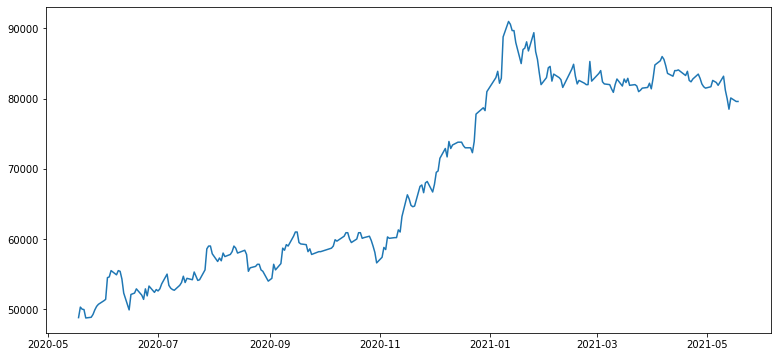

In [ ]:
# STEP 2 : 각종 전처리 수행
# 결측치 확인 : 결측치는 없음 / Series([], Name: Close, dtype: float64)
ts = ts.interpolate(method='time') # 보간 후 결측치 출력
ts[ts.isna()]
plt.plot(ts) # 안정성이 없는 것으로 추정되는 시계열 데이터

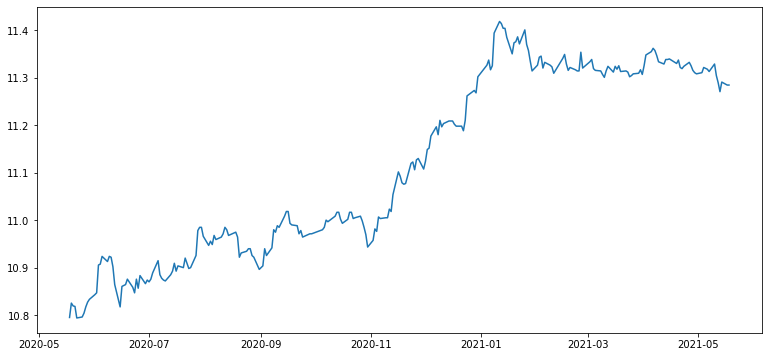

In [ ]:
# STEP 2 : 각종 전처리 수행
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [ ]:
# STEP 3 : 시계열 안정성 분석
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
# MA 그래프 함수 구현

def plot_rolling_statistics(timeseries, window=12):
    
  rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
  rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

   # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
  orig = plt.plot(timeseries, color='blue',label='Original')    
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

# ADF Test 함수 구현

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
  dftest = adfuller(timeseries, autolag='AIC')

  # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
  print('Result of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

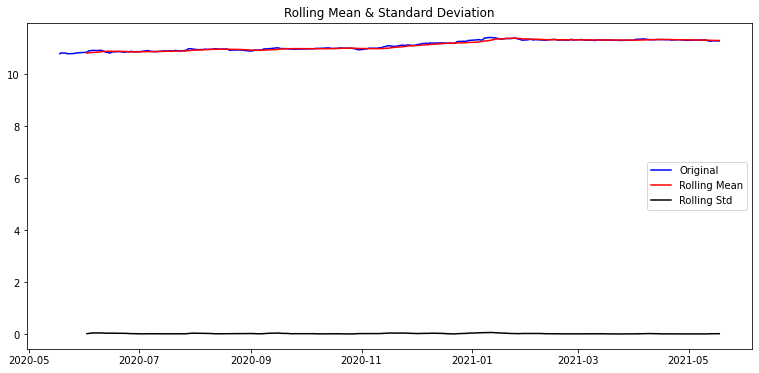

Result of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


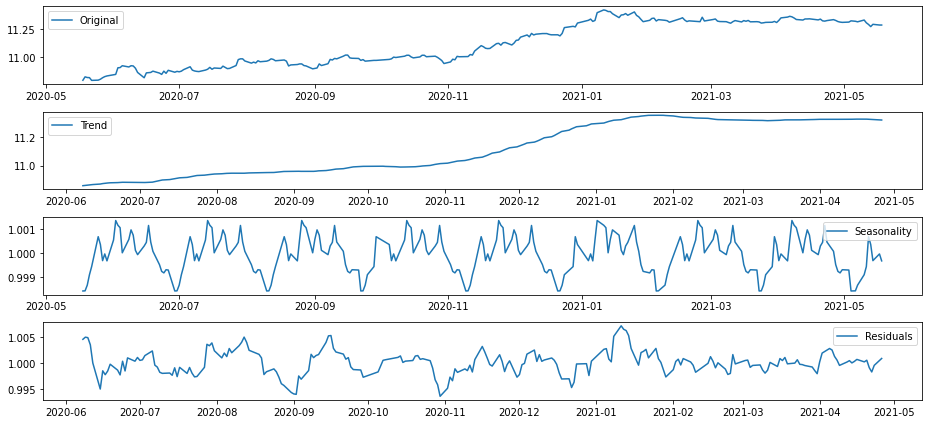

In [ ]:
# STEP 3 : 시계열 안정성 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 오리지널과 mean이 거의 일치하는 양상을 보여주고 있다.
# p-value가 0.590149이므로 안정적인 있는 시계열 데이터가 아니다.

In [ ]:
# Residual 안정성 여부
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
# p-value : 6.234854e-08
# Decomposing을 통해 얻은 residual의 p-value는 압도적으로 낮다. 이는 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다.

Result of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


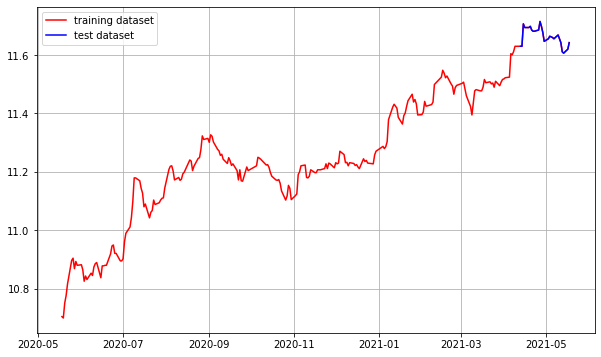

In [ ]:
# STEP 4 : 학습, 테스트 데이터셋 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

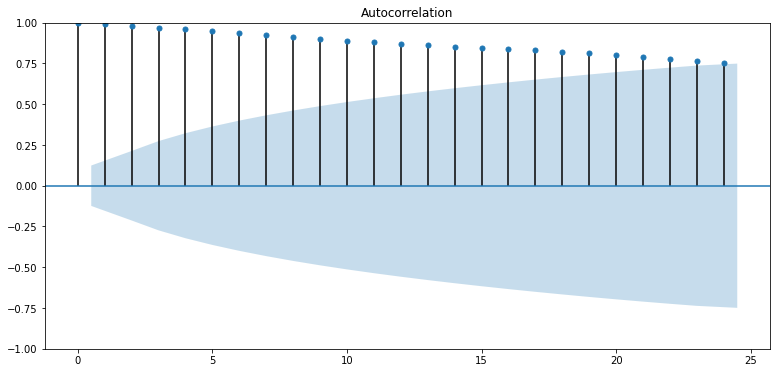

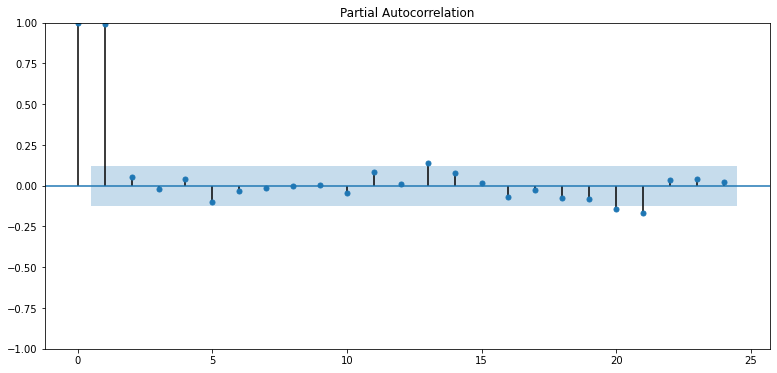

In [ ]:
# STEP 5 : 적정 ARIMA 모수 찾기
# ACF, PACF 그려서 적절한 p, q값 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# PACF 그래프를 보면 p = 2이 적절하다고 생각한다. p >= 3이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다.
# PACF=0이라는 의미는 현재 데이터와 p시점 떨어진 이전의 데이터는 아무 상관없는 데이터이기 고려할 필요가 없다.
# ACF는 점차 감소하고있어 AR(1) 모델에 유사한 형태를 보인다. q에 대한 적합한 값은 없는 것으로 판단되지만 1이라는 값으로 넣어보기로 한다.

Result of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Result of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


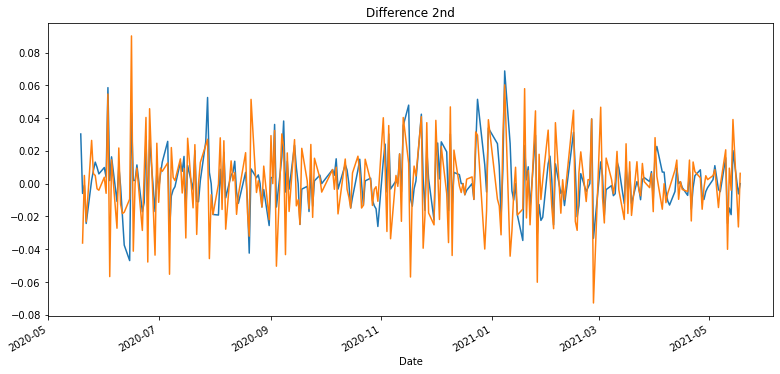

In [ ]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# p-value = 2.183738e-28

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# p-value = 3.525823e-18

# 1, 2차 차분에서 둘 다 현저하게 낮은 p-value값을 보여준다.
# # Residual 안정성 여부에서 이미 p-valuse값이 현저히 낮음을 확인했기에 d = 0으로 지정한다.

In [ ]:
# STEP 6 : ARIMA 모델 훈련과 테스트

from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Sun, 24 Jul 2022   AIC                          -1156.722
Time:                        11:50:14   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


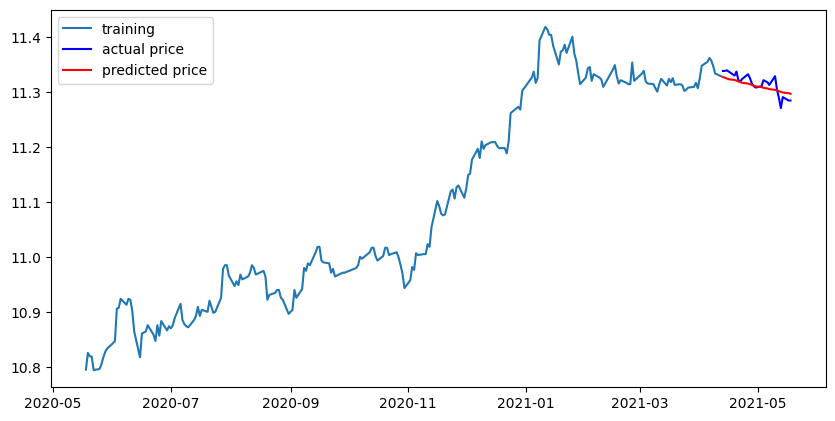

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014240584
MAE:  843.7579531509296
RMSE:  1024.194122920093
MAPE: 1.03%


# 다른 주식 종목도 예측해보기 (카카오)

In [2]:
# 모듈 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install statsmodels==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas
import sklearn
import statsmodels
print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__) # 버젼 개선 확인

1.3.5
1.0.2
0.13.0


In [33]:
# STEP 1 : 시계열 데이터 준비
df = pd.read_csv('035720.KS_kakao.csv', index_col='Date', parse_dates=True)
#df.head()
# 컬럼 설명
# 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)
# 종가만 사용한다
df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
ts= df['Close']
ts.head()

Date
2020-05-18    44525.031250
2020-05-19    44323.562500
2020-05-20    46640.476563
2020-05-21    47849.300781
2020-05-22    49763.273438
Name: Close, dtype: float64

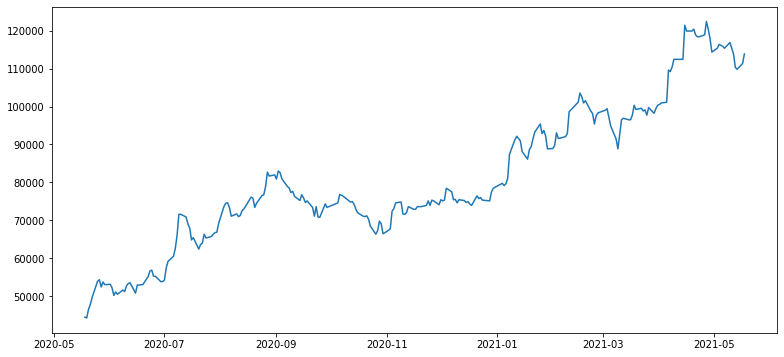

In [34]:
# STEP 2 : 각종 전처리 수행
# 결측치 확인 : 결측치는 없음 / Series([], Name: Close, dtype: float64)
ts = ts.interpolate(method='time') # 보간 후 결측치 출력
ts[ts.isna()]
plt.plot(ts) # 안정성이 없는 것으로 추정되는 시계열 데이터

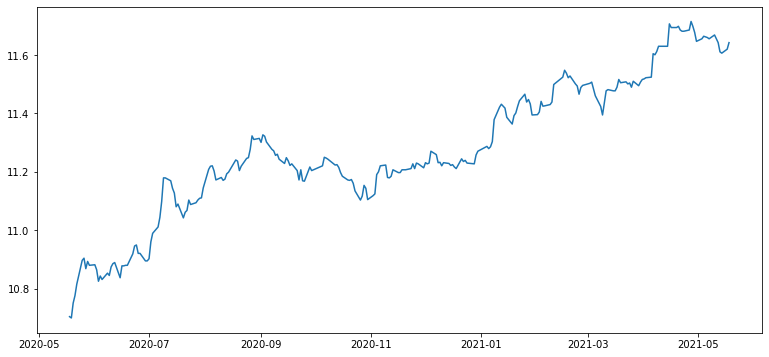

In [35]:
# STEP 2 : 각종 전처리 수행
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [36]:
# STEP 3 : 시계열 안정성 분석
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
# MA 그래프 함수 구현

def plot_rolling_statistics(timeseries, window=12):
    
  rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
  rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

   # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
  orig = plt.plot(timeseries, color='blue',label='Original')    
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

# ADF Test 함수 구현

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
  dftest = adfuller(timeseries, autolag='AIC')

  # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
  print('Result of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

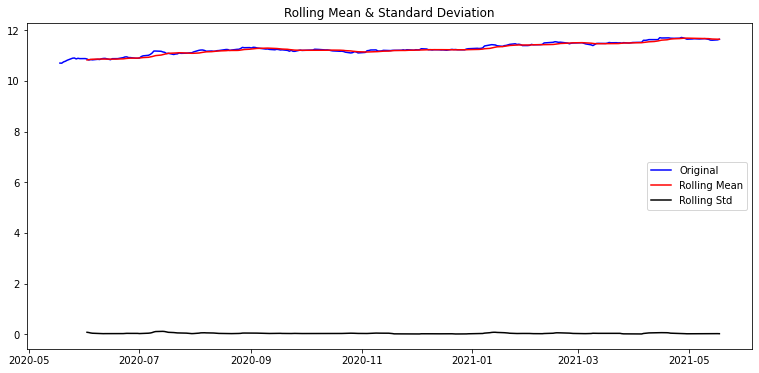

Result of Dickey-Fuller Test:
Test Statistic                  -1.909570
p-value                          0.327573
#Lags Used                       1.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


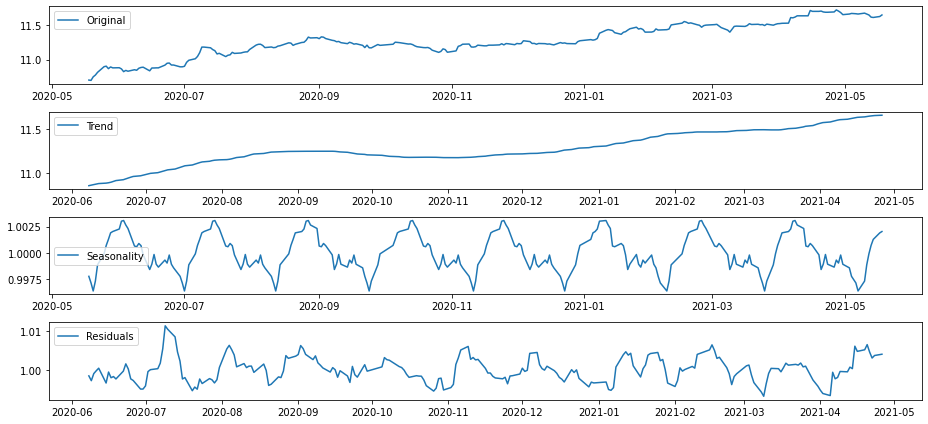

In [37]:
# STEP 3 : 시계열 안정성 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 오리지널과 mean이 거의 일치하는 양상을 보여주고 있다.
# p-value가 0.327573이므로 안정적인 시계열 데이터는 아니다.

In [38]:
# Residual 안정성 여부
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
# p-value : 4.533826e-08
# Decomposing을 통해 얻은 residual의 p-value는 압도적으로 낮다. 이는 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다.

Result of Dickey-Fuller Test:
Test Statistic                -6.247678e+00
p-value                        4.533826e-08
#Lags Used                     7.000000e+00
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


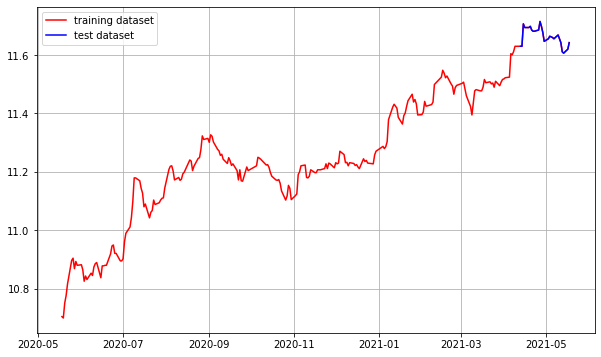

In [39]:
# STEP 4 : 학습, 테스트 데이터셋 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

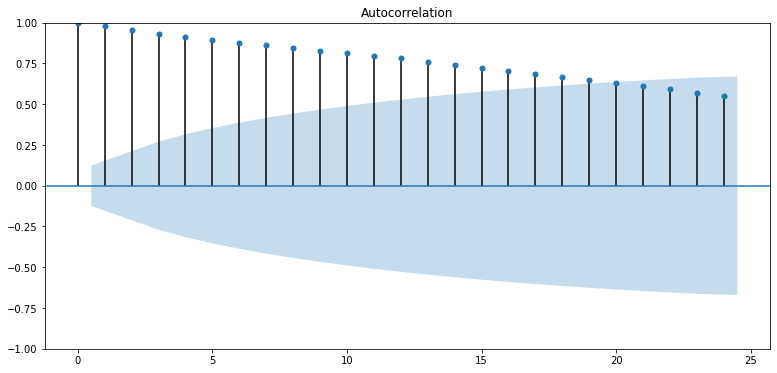

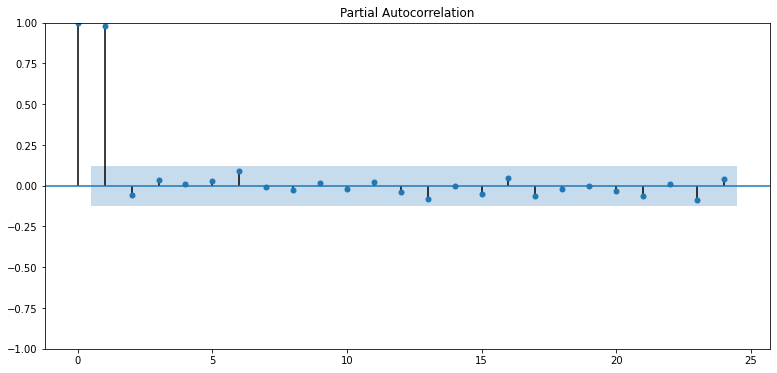

In [40]:
# STEP 5 : 적정 ARIMA 모수 찾기
# ACF, PACF 그려서 적절한 p, q값 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# PACF 그래프를 보면 p = 1이 적절하다고 생각한다. p >= 2이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다.
# PACF=0이라는 의미는 현재 데이터와 p시점 떨어진 이전의 데이터는 아무 상관없는 데이터이기 고려할 필요가 없다.
# ACF는 점차 감소하고있어 AR(1) 모델에 유사한 형태를 보인다. q에 대한 적합한 값은 없는 것으로 판단되지만 1이라는 값으로 넣어보기로 한다.

Result of Dickey-Fuller Test:
Test Statistic                -1.336560e+01
p-value                        5.321088e-25
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Result of Dickey-Fuller Test:
Test Statistic                -7.341426e+00
p-value                        1.062690e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


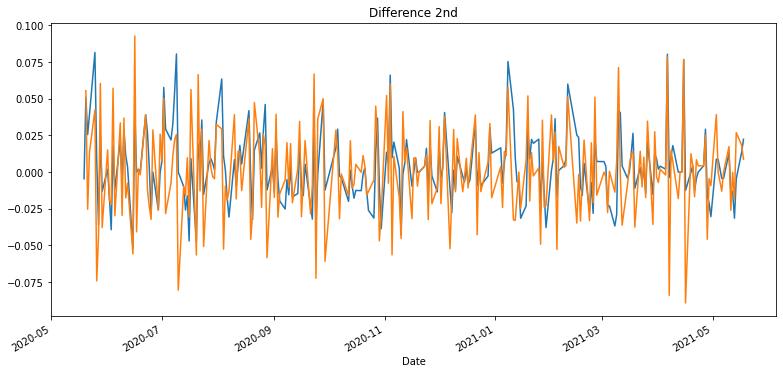

In [41]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# p-value = 5.321088e-25

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# p-value = 1.062690e-10

# 1, 2차 차분에서 둘 다 현저하게 낮은 p-value값을 보여준다.
# # Residual 안정성 여부에서 이미 p-valuse값이 현저히 낮음을 확인했기에 d = 0으로 지정한다.

In [43]:
# STEP 6 : ARIMA 모델 훈련과 테스트

from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 0, 1)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 516.587
Date:                Fri, 29 Jul 2022   AIC                          -1025.173
Time:                        06:54:55   BIC                          -1011.509
Sample:                             0   HQIC                         -1019.658
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1990      0.392     28.581      0.000      10.431      11.967
ar.L1          0.9974      0.008    121.800      0.000       0.981       1.013
ma.L1          0.1679      0.070      2.388      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


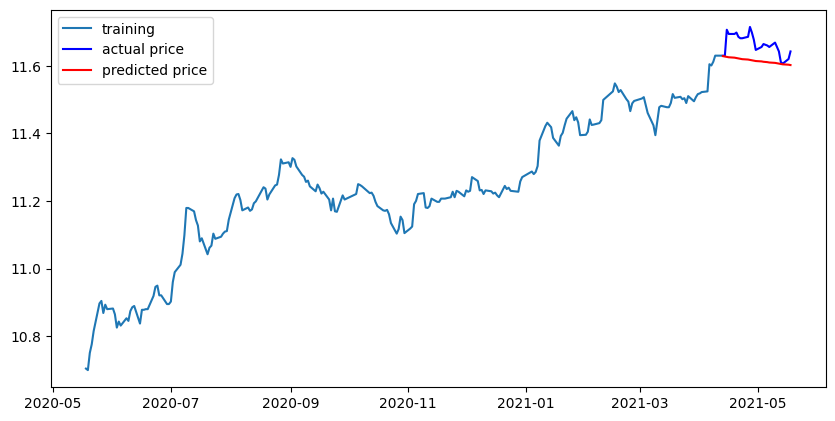

In [44]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  40945849.98063681
MAE:  5619.586976501804
RMSE:  6398.894434246967
MAPE: 4.76%


# 다른 주식 종목도 예측해보기 (네이버)

In [ ]:
# 모듈 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install statsmodels==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas
import sklearn
import statsmodels
print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__) # 버젼 개선 확인

1.3.5
1.0.2
0.13.0


In [ ]:
# STEP 1 : 시계열 데이터 준비
df = pd.read_csv('035420.KS_naver.csv', index_col='Date', parse_dates=True)
#df.head()
# 컬럼 설명
# 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)
# 종가만 사용한다
df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
ts= df['Close']
ts.head()

Date
2020-05-18    215000.0
2020-05-19    213500.0
2020-05-20    222000.0
2020-05-21    225000.0
2020-05-22    230500.0
Name: Close, dtype: float64

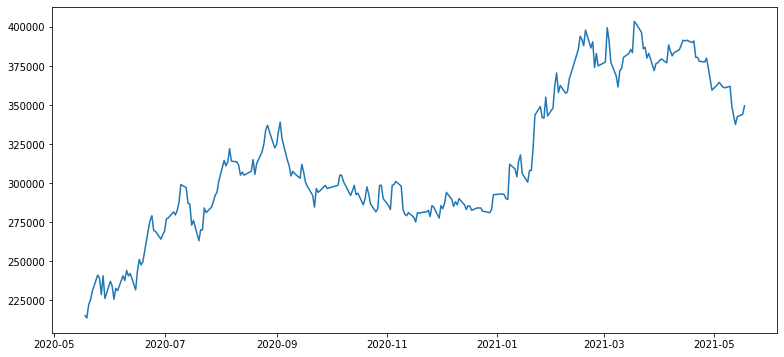

In [ ]:
# STEP 2 : 각종 전처리 수행
# 결측치 확인 : 결측치는 없음 / Series([], Name: Close, dtype: float64)
ts = ts.interpolate(method='time') # 보간 후 결측치 출력
ts[ts.isna()]
plt.plot(ts) # 안정성이 없는 것으로 추정되는 시계열 데이터

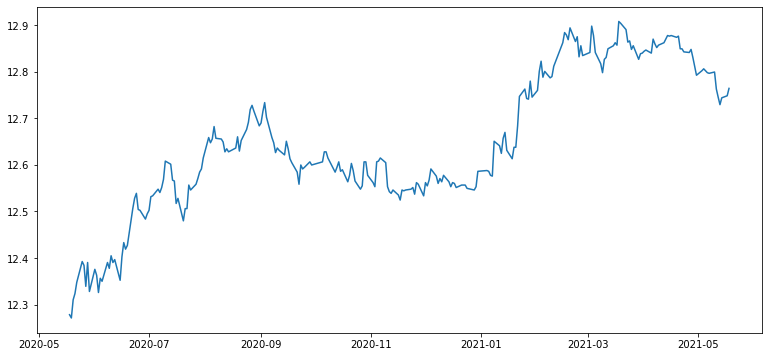

In [ ]:
# STEP 2 : 각종 전처리 수행
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [ ]:
# STEP 3 : 시계열 안정성 분석
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
# MA 그래프 함수 구현

def plot_rolling_statistics(timeseries, window=12):
    
  rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
  rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

   # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
  orig = plt.plot(timeseries, color='blue',label='Original')    
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

# ADF Test 함수 구현

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
  dftest = adfuller(timeseries, autolag='AIC')

  # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
  print('Result of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

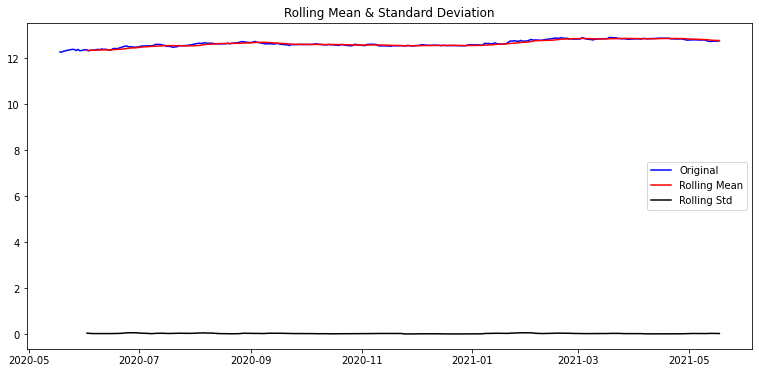

Result of Dickey-Fuller Test:
Test Statistic                  -2.312264
p-value                          0.168043
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


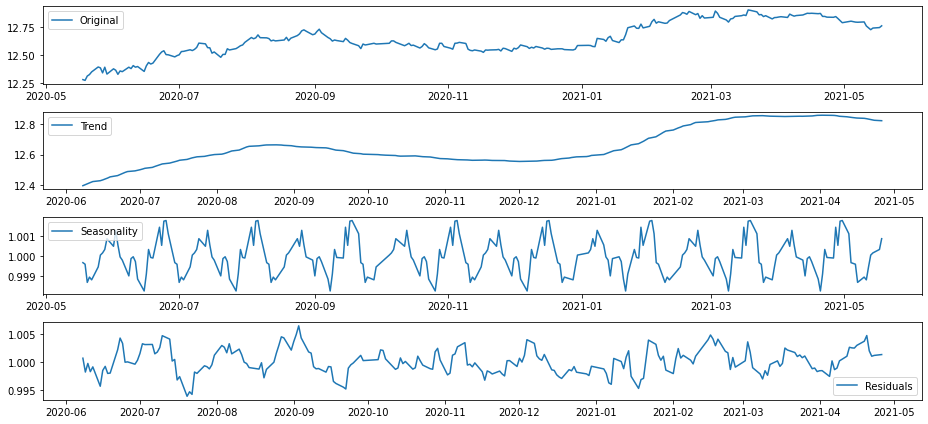

In [ ]:
# STEP 3 : 시계열 안정성 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 오리지널과 mean이 거의 일치하는 양상을 보여주고 있다.
# p-value가 0.168043이므로 안정적인 시계열 데이터는 아니다.

In [ ]:
# Residual 안정성 여부
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
# p-value : 2.331583e-07
# Decomposing을 통해 얻은 residual의 p-value는 압도적으로 낮다. 이는 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다.

Result of Dickey-Fuller Test:
Test Statistic                -5.935052e+00
p-value                        2.331583e-07
#Lags Used                     1.000000e+00
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64


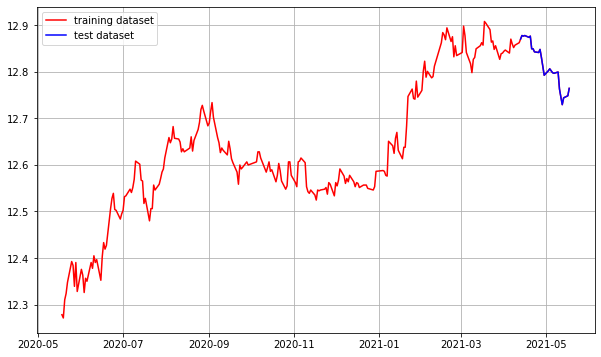

In [ ]:
# STEP 4 : 학습, 테스트 데이터셋 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

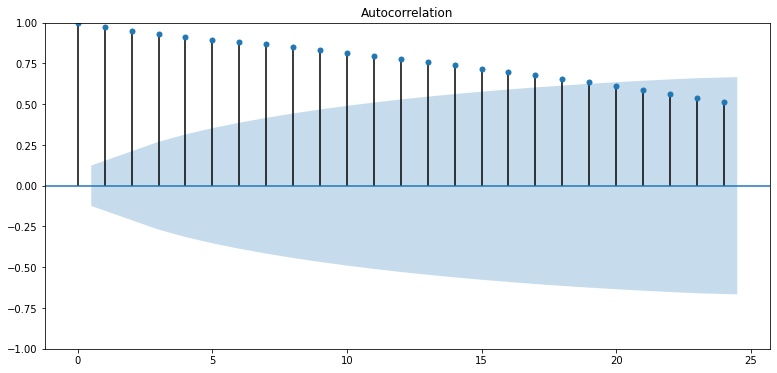

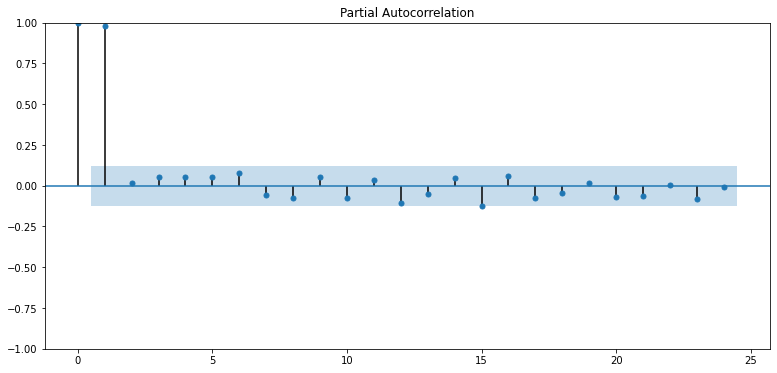

In [ ]:
# STEP 5 : 적정 ARIMA 모수 찾기
# ACF, PACF 그려서 적절한 p, q값 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# PACF 그래프를 보면 p = 1이 적절하다고 생각한다. p >= 2이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다.
# PACF=0이라는 의미는 현재 데이터와 p시점 떨어진 이전의 데이터는 아무 상관없는 데이터이기 고려할 필요가 없다.
# ACF는 점차 감소하고있어 AR(1) 모델에 유사한 형태를 보인다. q에 대한 적합한 값은 없는 것으로 판단되지만 1이라는 값으로 넣어보기로 한다.

Result of Dickey-Fuller Test:
Test Statistic                -1.683713e+01
p-value                        1.145775e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Result of Dickey-Fuller Test:
Test Statistic                -7.459419e+00
p-value                        5.403243e-11
#Lags Used                     1.500000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


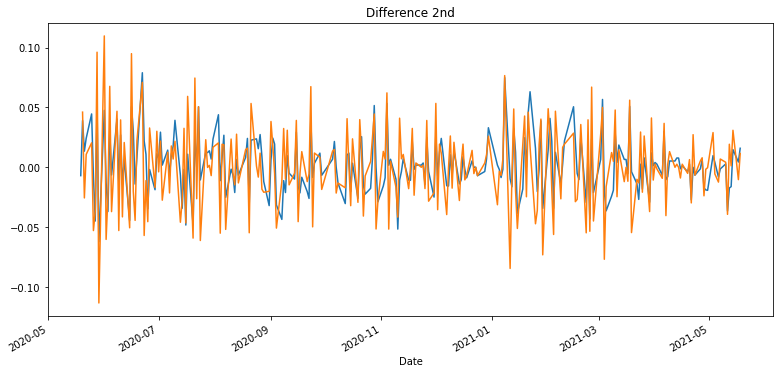

In [ ]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# p-value = 1.145775e-29

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# p-value = 5.403243e-11

# 1, 2차 차분에서 둘 다 현저하게 낮은 p-value값을 보여준다.
# # Residual 안정성 여부에서 이미 p-valuse값이 현저히 낮음을 확인했기에 d = 0으로 지정한다.

In [ ]:
# STEP 6 : ARIMA 모델 훈련과 테스트

from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 0, 1)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 515.997
Date:                Sun, 24 Jul 2022   AIC                          -1023.993
Time:                        12:22:13   BIC                          -1010.329
Sample:                             0   HQIC                         -1018.478
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5893      0.181     69.618      0.000      12.235      12.944
ar.L1          0.9953      0.009    113.176      0.000       0.978       1.012
ma.L1         -0.0732      0.069     -1.054      0.2

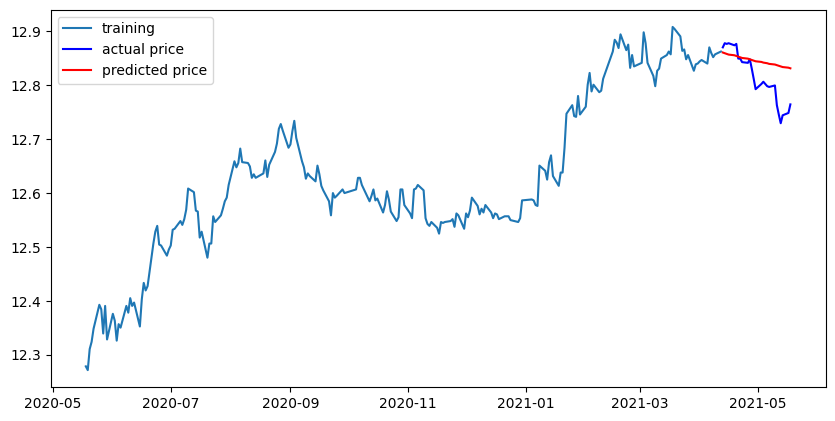

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  307850534.9306709
MAE:  13810.31471425827
RMSE:  17545.66997668288
MAPE: 3.88%


# 다른 주식 종목도 예측해보기 (posco)

In [ ]:
# 모듈 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install statsmodels==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas
import sklearn
import statsmodels
print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__) # 버젼 개선 확인

1.3.5
1.0.2
0.13.0


In [46]:
# STEP 1 : 시계열 데이터 준비
df = pd.read_csv('005490.KS_posco.csv', index_col='Date', parse_dates=True)
#df.head()
# 컬럼 설명
# 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)
# 종가만 사용한다
df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
ts= df['Close']
ts.head()

Date
2020-05-18    169000.0
2020-05-19    178000.0
2020-05-20    174500.0
2020-05-21    177000.0
2020-05-22    172000.0
Name: Close, dtype: float64

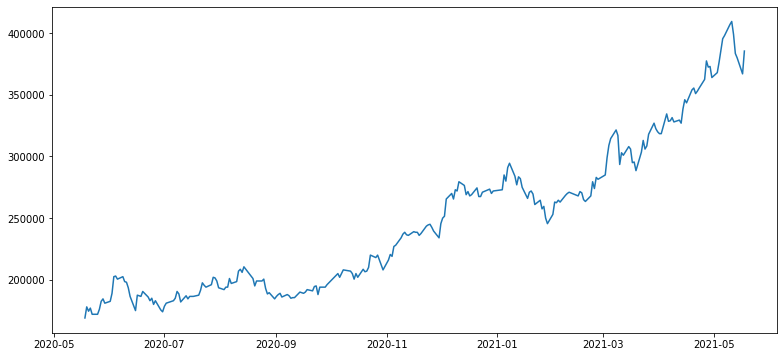

In [47]:
# STEP 2 : 각종 전처리 수행
# 결측치 확인 : 결측치는 없음 / Series([], Name: Close, dtype: float64)
ts = ts.interpolate(method='time') # 보간 후 결측치 출력
ts[ts.isna()]
plt.plot(ts) # 안정성이 없는 것으로 추정되는 시계열 데이터

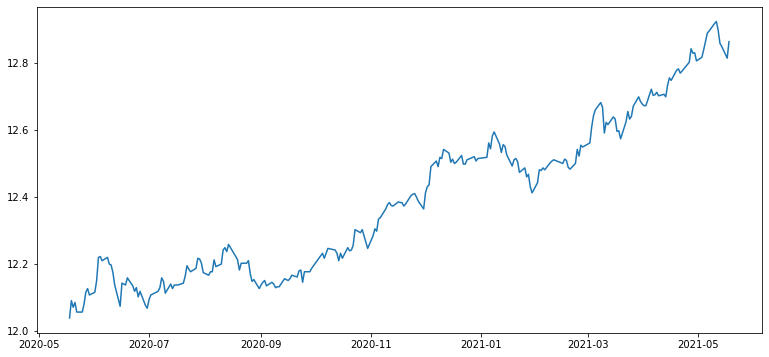

In [48]:
# STEP 2 : 각종 전처리 수행
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [50]:
# STEP 3 : 시계열 안정성 분석
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
# MA 그래프 함수 구현

def plot_rolling_statistics(timeseries, window=12):
    
  rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
  rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

   # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
  orig = plt.plot(timeseries, color='blue',label='Original')    
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

# ADF Test 함수 구현

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
  dftest = adfuller(timeseries, autolag='AIC')

  # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
  print('Result of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

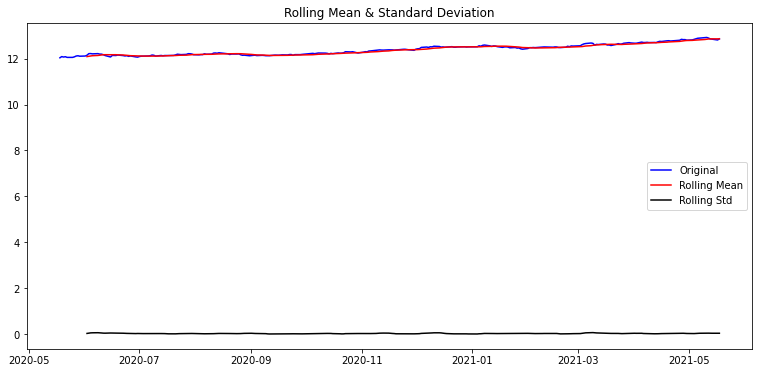

Result of Dickey-Fuller Test:
Test Statistic                  -0.155027
p-value                          0.943674
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


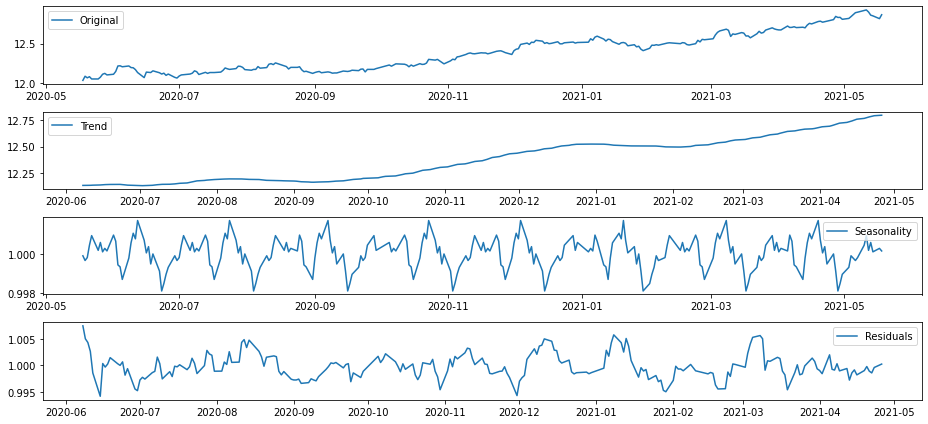

In [51]:
# STEP 3 : 시계열 안정성 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 오리지널과 mean이 거의 일치하는 양상을 보여주고 있다.
# p-value가 0.943674이므로 안정적인 시계열 데이터는 아니다.

In [52]:
# Residual 안정성 여부
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
# p-value : 4.970107e-08
# Decomposing을 통해 얻은 residual의 p-value는 압도적으로 낮다. 이는 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다.

Result of Dickey-Fuller Test:
Test Statistic                -6.230382e+00
p-value                        4.970107e-08
#Lags Used                     0.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


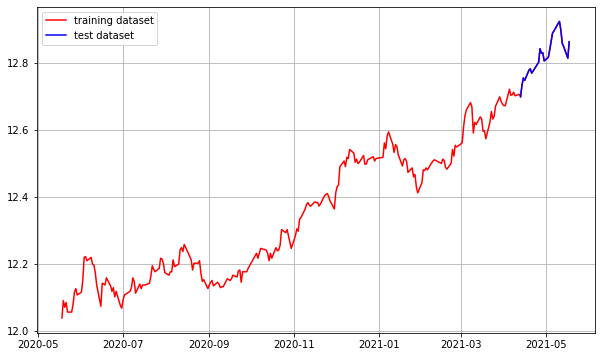

In [53]:
# STEP 4 : 학습, 테스트 데이터셋 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
# train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

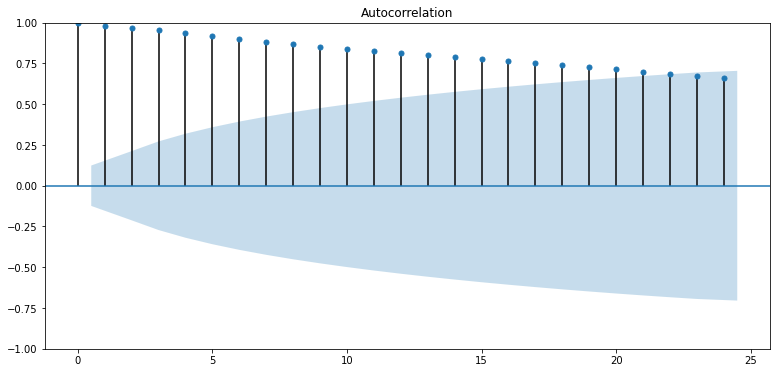

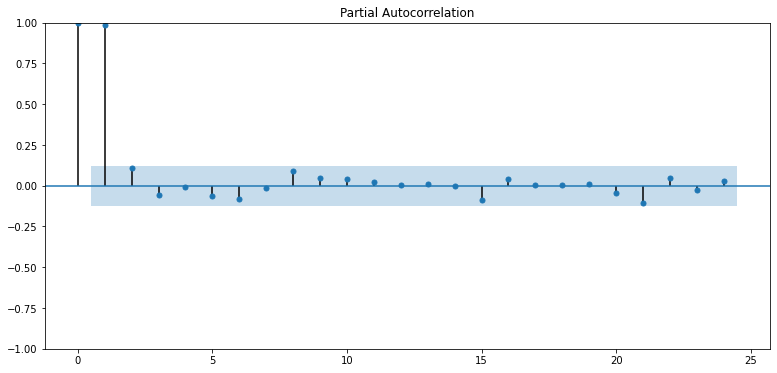

In [54]:
# STEP 5 : 적정 ARIMA 모수 찾기
# ACF, PACF 그려서 적절한 p, q값 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# PACF 그래프를 보면 p = 1이 적절하다고 생각한다. p >= 2이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다.
# PACF=0이라는 의미는 현재 데이터와 p시점 떨어진 이전의 데이터는 아무 상관없는 데이터이기 고려할 필요가 없다.
# ACF는 점차 감소하고있어 AR(1) 모델에 유사한 형태를 보인다. q에 대한 적합한 값은 없는 것으로 판단되지만 1이라는 값으로 넣어보기로 한다.

Result of Dickey-Fuller Test:
Test Statistic                -1.644194e+01
p-value                        2.423211e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Result of Dickey-Fuller Test:
Test Statistic                -8.289570e+00
p-value                        4.298050e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


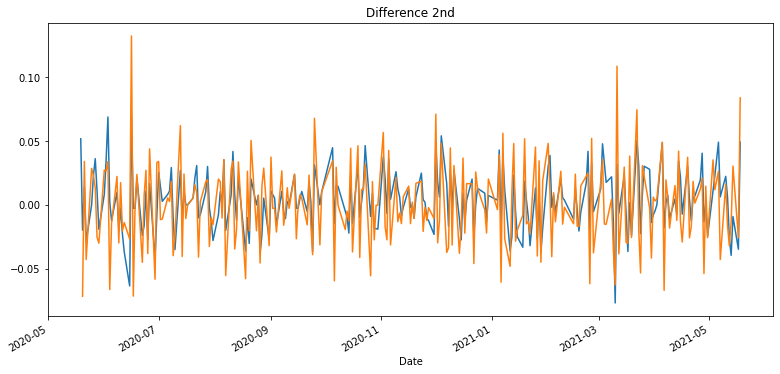

In [55]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# p-value = 2.423211e-29

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# p-value = 4.298050e-13

# 1, 2차 차분에서 둘 다 현저하게 낮은 p-value값을 보여준다.
# # Residual 안정성 여부에서 이미 p-valuse값이 현저히 낮음을 확인했기에 d = 0으로 지정한다.

In [62]:
# STEP 6 : ARIMA 모델 훈련과 테스트

from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 0, 1)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 528.258
Date:                Fri, 29 Jul 2022   AIC                          -1048.516
Time:                        06:57:46   BIC                          -1034.852
Sample:                             0   HQIC                         -1043.001
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3392      0.259     47.615      0.000      11.831      12.847
ar.L1          0.9973      0.007    136.912      0.000       0.983       1.012
ma.L1         -0.0379      0.062     -0.616      0.5

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


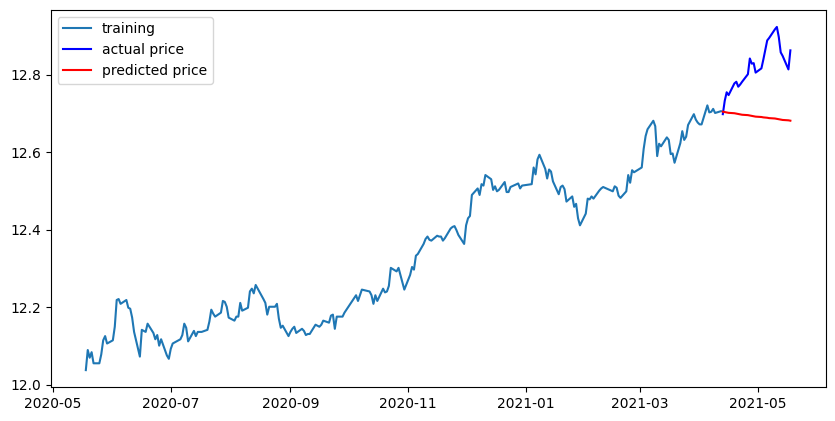

In [63]:
# Forecast : 결과가 fc에 담깁니다. 
fc= fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()
# 예측과 실제과 완전히 다른 방향으로 출력되었다.
# 

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2516480205.2553616
MAE:  44611.302645007505
RMSE:  50164.531346912445
MAPE: 11.75%


# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) ACF, PACF 이론을 이해하는 것이 쉽지 않았습니다. 추가적인 이론 공부가 필요하다고 생각합니다.

 (2) arima모델의 (p,d,q) 값들을 변화시켜 그려보았으나 뚜렷한 차이점을 느끼지 못했습니다. 제가 이론에 대한 이해가 부족해서 그런거라고 생각합니다.
 

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) colab에서 구동할 때 발생한 문제점과 해결방안
- 문제점 : 모델 fit 결과가 이상하게 출력
- 해결 방안 statsmodel 버젼 0.13으로 Install

(2) 다시 공부한 ACF, PACF 이론

#### acf(자기상관함수)란
- 시차에 따른 일련의 자기상관을 의미하며, 시차는 커질수록 acf는 0에 가까워진다.
- 정상시계열은 상대적으로 빠르게 0에 수렴, 비정상 시계열은 천천히 감소한다.
- 분석에 사용한 주식데이터는 대부분 우상향하는 비정상 시계열데이터이다.
- 그러므로 adf그래프가 천천히 감소하는 경향을 보인다.

#### pacf(편자기상관함수)란
- 시차에 따른 일련의 편자기상관이며, 시차가 다른 두 시계열 데이터 간의 순수한 상호 연관성이다.



참조

(1) [acf, pacf이론](https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80)
